In [1]:
import math
import torch
import time

import gpytorch

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from gpytorch.likelihoods import (
    _MultitaskGaussianLikelihoodBase,
    MultitaskGaussianLikelihood,
    MultitaskGaussianLikelihoodKronecker,
    HeteroskedasticNoise,
)


class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks, rank=0):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_tasks, rank=rank
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [3]:
train_x = torch.linspace(0, 1, 75)

sem_y1 = 0.05 + (0.75 - 0.05) * torch.linspace(0, 1, 75)
sem_y2 = 0.75 - (0.75 - 0.05) * torch.linspace(0, 1, 75)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + sem_y1 * torch.randn(train_x.size()),
    torch.cos(train_x * (2 * math.pi)) + sem_y2 * torch.randn(train_x.size()),
], -1)

train_y_log_var = torch.stack([(s**2).log() for s in (sem_y1, sem_y2)], -1)

## Basic Model inferring a homoskedastic noise

In [4]:
likelihood = MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood, num_tasks=2)

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 75
tic = time.time()
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y, train_x)
    loss.backward()
    if (i+1) % 10 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

print(f"wall time: {time.time() - tic:.2f}")

Iter 10/75 - Loss: 74.447
Iter 20/75 - Loss: 57.906
Iter 30/75 - Loss: 56.098
Iter 40/75 - Loss: 54.897
Iter 50/75 - Loss: 55.728
Iter 60/75 - Loss: 53.689
Iter 70/75 - Loss: 54.815
wall time: 2.68


In [6]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.fast_pred_var():
    test_x = torch.linspace(0, 1, 35)
    post_f = model(test_x)
    post_obs = likelihood(post_f, test_x)

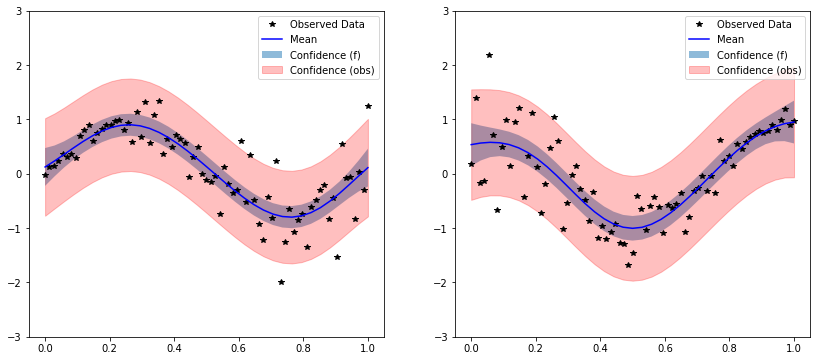

In [7]:
with torch.no_grad():
    f, axs = plt.subplots(1, 2, figsize=(14, 6))
    lower_f, upper_f = post_f.confidence_region()
    lower_obs, upper_obs = post_obs.confidence_region()
    for i, ax in enumerate(axs):
        ax.plot(train_x.numpy(), train_y[:, i].numpy(), 'k*')
        ax.plot(test_x.numpy(), post_f.mean[:, i].numpy(), 'b')
        ax.fill_between(test_x.numpy(), lower_f[:, i].numpy(), upper_f[:, i].numpy(), alpha=0.5)
        ax.fill_between(test_x.numpy(), lower_obs[:, i].numpy(), upper_obs[:, i].numpy(), alpha=0.25, color='r')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence (f)', 'Confidence (obs)'])

## Basic Model inferring a homoskedastic noise (Kronecker product)

We may expect this to be faster, but it is not...

In [8]:
likelihood = MultitaskGaussianLikelihoodKronecker(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood, num_tasks=2)

In [9]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 75
tic = time.time()
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y, train_x)
    loss.backward()
    if (i+1) % 10 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()
    
print(f"wall time: {time.time() - tic:.2f}")

Iter 10/75 - Loss: 74.332
Iter 20/75 - Loss: 57.854
Iter 30/75 - Loss: 55.752
Iter 40/75 - Loss: 54.626
Iter 50/75 - Loss: 55.031
Iter 60/75 - Loss: 54.200
Iter 70/75 - Loss: 55.033
wall time: 2.99


In [10]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.fast_pred_var():
    test_x = torch.linspace(0, 1, 35)
    post_f = model(test_x)
    post_obs = likelihood(post_f, test_x)

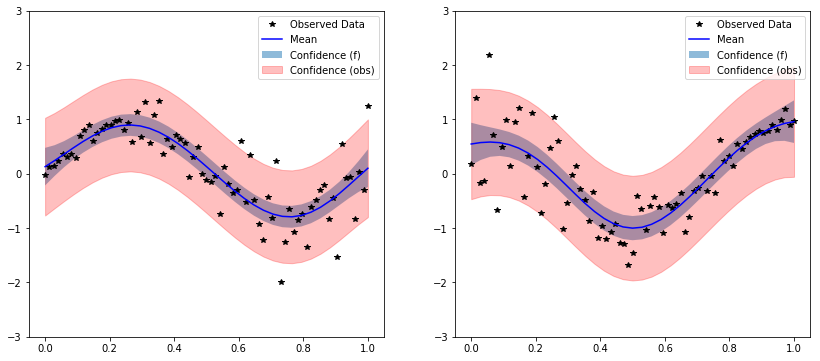

In [11]:
with torch.no_grad():
    f, axs = plt.subplots(1, 2, figsize=(14, 6))
    lower_f, upper_f = post_f.confidence_region()
    lower_obs, upper_obs = post_obs.confidence_region()
    for i, ax in enumerate(axs):
        ax.plot(train_x.numpy(), train_y[:, i].numpy(), 'k*')
        ax.plot(test_x.numpy(), post_f.mean[:, i].numpy(), 'b')
        ax.fill_between(test_x.numpy(), lower_f[:, i].numpy(), upper_f[:, i].numpy(), alpha=0.5)
        ax.fill_between(test_x.numpy(), lower_obs[:, i].numpy(), upper_obs[:, i].numpy(), alpha=0.25, color='r')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence (f)', 'Confidence (obs)'])

## Complex Model using multi-task GP trained on noise observations as a heteroskedastic noise model

In [12]:
log_noise_model = MultitaskGPModel(
    train_x,
    train_y_log_var,
    MultitaskGaussianLikelihood(num_tasks=2),
    num_tasks=2,
)

likelihood = _MultitaskGaussianLikelihoodBase(
    num_tasks=2,
    noise_covar=HeteroskedasticNoise(log_noise_model),
)
model = MultitaskGPModel(train_x, train_y, likelihood, num_tasks=2, rank=2)

In [13]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 75
tic = time.time()
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y, train_x)
    loss.backward()
    if (i+1) % 10 == 0:
        print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()
print(f"wall time: {time.time() - tic:.2f}")

Iter 10/75 - Loss: 64.205
Iter 20/75 - Loss: 55.603
Iter 30/75 - Loss: 56.734
Iter 40/75 - Loss: 53.232
Iter 50/75 - Loss: 54.166
Iter 60/75 - Loss: 53.215
Iter 70/75 - Loss: 52.984
wall time: 1.49


In [14]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.fast_pred_var():
    test_x = torch.linspace(0, 1, 35)
    post_f = model(test_x)
    post_obs = likelihood(post_f, test_x)

/home/bgavin/anaconda3/envs/sar/lib/python3.6/site-packages/gpytorch/models/exact_gp.py:177: UserWarning: The input matches the stored training data. Did you forget to call model.train()?
  "The input matches the stored training data. Did you forget to call model.train()?", UserWarning


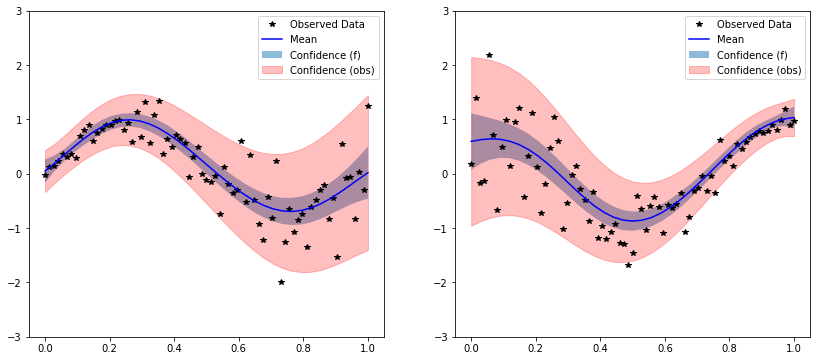

In [15]:
with torch.no_grad():
    f, axs = plt.subplots(1, 2, figsize=(14, 6))
    lower_f, upper_f = post_f.confidence_region()
    lower_obs, upper_obs = post_obs.confidence_region()
    for i, ax in enumerate(axs):
        ax.plot(train_x.numpy(), train_y[:, i].numpy(), 'k*')
        ax.plot(test_x.numpy(), post_f.mean[:, i].numpy(), 'b')
        ax.fill_between(test_x.numpy(), lower_f[:, i].numpy(), upper_f[:, i].numpy(), alpha=0.5)
        ax.fill_between(test_x.numpy(), lower_obs[:, i].numpy(), upper_obs[:, i].numpy(), alpha=0.25, color='r')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence (f)', 'Confidence (obs)'])